## Описание проекта

Есть исторические данные по количеству заказов такси в определенном районе. Необходимо спрогнозировать пиковые нагрузки чтобы вовремя привлечь дополнительных водителей. 

Для решения задачи обучим различные модели, которые будут предсказывать количество заказов такси в следующий час.

В качестве метрики выбрана *RMSE*. Итоговое значение на тестовой выборке должно быть не больше 48.

## План исследования
1. Подготовка
2. Анализ
3. Обучение
4. Тестирование
Общий вывод

# 1. Подготовка <a id='section1'></a>

Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Загрузим данные и выполним ресемплирование

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C07EDC8>]],
      dtype=object)

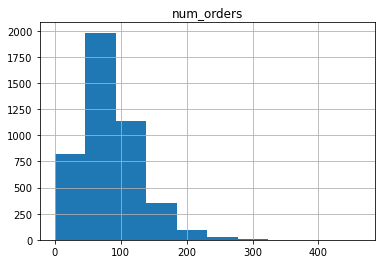

In [2]:
df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
df = df.resample('1H').sum()
print(df)
df.hist()

### Вывод:
Данные загружены, ресемплирование выполненно. Распределение выглядит нормально. 

# 2. Анализ <a id='section2'></a>

Создадим необходимые признаки. Заранее зададим rolling_mean_size и max_lag, чтобы в будущем было легче эксперементировать. 

In [3]:
rolling_mean_size = 3
max_lag = 13  # Подобран опытным путем

df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour
df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

for lag in range(1, max_lag + 1):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

В заданом периоде были праздничные дни. Это могло повлиять на количество заказов. Создадим колонку для указания праздничных дней. 

In [4]:
df['holiday'] = 0

Обозначим официальные праздничные дни вручную

In [5]:
df.loc['2018-03-08 00:00:00' : '2018-03-11 23:00:00', 'holiday'] = 1
df.loc['2018-04-29 00:00:00' : '2018-05-02 23:00:00', 'holiday'] = 1
df.loc['2018-05-09 00:00:00' : '2018-05-09 23:00:00', 'holiday'] = 1
df.loc['2018-06-10 00:00:00' : '2018-06-12 23:00:00', 'holiday'] = 1

Поменяем тип категориальных данных

In [6]:
df['month'] = df['month'].astype('category')
df['day'] = df['day'].astype('category')
df['dayofweek'] = df['dayofweek'].astype('category')
df['hour'] = df['hour'].astype('category')
df['holiday'] = df['holiday'].astype('category')

Избавимся от пропусков

In [7]:
df = df.dropna()
features = df.drop(['num_orders'], axis=1)
target = df['num_orders']

In [8]:
df

,num_orders,month,day,dayofweek,hour,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,holiday
datetime,,,,,,,,,,,,,,,,,,,,
2018-03-01 13:00:00,32,3,1,3,13,63.333333,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,0
2018-03-01 14:00:00,48,3,1,3,14,52.666667,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,0
2018-03-01 15:00:00,66,3,1,3,15,36.666667,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,0
2018-03-01 16:00:00,43,3,1,3,16,48.666667,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,0
2018-03-01 17:00:00,44,3,1,3,17,52.333333,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.000000,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,0
2018-08-31 20:00:00,154,8,31,4,20,186.666667,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,0
2018-08-31 21:00:00,159,8,31,4,21,165.666667,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,0


### Вывод:
Признаки подготовлены к обучению 

# 3. Обучение <a id='section3'></a>

Разделим данные на обучающие, валидационные и тестовые 

In [9]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, shuffle=False, test_size=0.2)

### Линейная регрессия 

In [10]:
model_Linear = LinearRegression()
 
model_Linear.fit(features_train, target_train)

valid_pred = model_Linear.predict(features_valid)
RMSE_Linear = mean_squared_error(valid_pred, target_valid) ** 0.5

print("RMSE валидационной выборки: ", RMSE_Linear)

RMSE валидационной выборки:  38.56117368758236


### Случайный лес

Напишем цикл, перебирающий параметры и записывающий их вместе с результатом в таблицу. Цикл закомментирован для экономии времени.

*Сейчас для таких задач использую GridSearchCV и RandomizedSearchCV

In [11]:
# %%time

# tree_parameters = pd.DataFrame(columns=['max_depth', 'min_samples_split', 'min_samples_leaf', 'n_estimators', 'RMSE'])

# for depth in range(2, 21, 2):
#     for split in range(2, 5):
#         for leaf in range(1, 5):
#             for estimators in range(90,110,10):
#                 model = RandomForestRegressor(min_samples_split=split, min_samples_leaf=leaf, 
#                                               max_depth=depth, n_estimators=estimators, random_state=12345)
#                 model.fit(features_train, target_train)
#                 predictions_valid = model.predict(features_valid)

#                 RMSE = mean_squared_error(predictions_valid, target_valid) ** 0.5
#                 result = pd.DataFrame([[depth, split, leaf, estimators, RMSE]])
#                 result.columns = ['max_depth', 'min_samples_split', 'min_samples_leaf', 'n_estimators', 'RMSE']
#                 tree_parameters = tree_parameters.append(result)

# tree_parameters.sort_values(by=['RMSE']).head(10)

Лучшие параметры: max_depth=18, min_samples_leaf=2, min_samples_split=3, n_estimators=90

In [12]:
model_RFR = RandomForestRegressor(min_samples_split=3, min_samples_leaf=2, 
                                              max_depth=18, n_estimators=90, random_state=12345)
 
model_RFR.fit(features_train, target_train)

valid_pred = model_RFR.predict(features_valid)
RMSE_RFR = mean_squared_error(valid_pred, target_valid) ** 0.5

print("RMSE валидационной выборки: ", RMSE_RFR)

RMSE валидационной выборки:  32.23069144515289


### LGBM

Подберем оптимальные параметры через цикл 

In [13]:
# %%time

# LGBM_parameters = pd.DataFrame(columns=['max_depth', 'num_leaves', 'learning_rate', 'n_estimators', 'RMSE'])

# for max_depth in range(2, 21, 2):
#     for num_leaves in range(70, 130, 10):
#         for learning_rate in np.arange(0.3, 0.9, 0.1):
#             for n_estimators in range(80, 120, 10):
#                 model = lgb.LGBMRegressor(max_depth=max_depth, num_leaves=num_leaves, 
#                                               learning_rate=learning_rate, n_estimators=n_estimators, random_state=12345)
#                 model.fit(features_train, target_train)
#                 predictions_valid = model.predict(features_valid)

#                 RMSE = mean_squared_error(predictions_valid, target_valid) ** 0.5
            
#                 result = pd.DataFrame([[max_depth, num_leaves, learning_rate, n_estimators, RMSE]])
#                 result.columns = ['max_depth', 'num_leaves', 'learning_rate', 'n_estimators', 'RMSE']
#                 LGBM_parameters = LGBM_parameters.append(result)

# LGBM_parameters.sort_values(by=['RMSE']).head(10)

Лучшие параметры: max_depth=2, num_leaves=70, learning_rate=0.3, n_estimators=80	

In [14]:
model_LGBM = lgb.LGBMRegressor(max_depth=2, num_leaves=70, learning_rate=0.3, n_estimators=80)

model_LGBM.fit(features_train, target_train)

valid_pred = model_LGBM.predict(features_valid)
RMSE_LGBM = mean_squared_error(valid_pred, target_valid) ** 0.5

print("RMSE валидационной выборки: ", RMSE_LGBM)

RMSE валидационной выборки:  33.30323125530132


In [15]:
print('Linear', RMSE_Linear.round(2))
print('RFR', RMSE_RFR.round(2))
print('LGBM', RMSE_LGBM.round(2))

Linear 38.56
RFR 32.23
LGBM 33.3


### Вывод:
Лучший результат на валидационных данных показала модель случайного леса. LGBM не сильно уступает в качестве прогнозов. Хуже всех качество прогнозов у модели линейной регрессии. 

Тем не менее стоит проверить все модели на тестовых данных. 

# 4. Тестирование <a id='section4'></a>

Необходимо переобучить все модели на обучающих и валидационных данных. Для этого объеденим все данные кроме тестовых. 

In [16]:
features_full = features_train.append(features_valid)
target_full = target_train.append(target_valid)

#### Модель линейной регрессии

In [17]:
model_Linear = LinearRegression()

model_Linear.fit(features_full, target_full)
predictions_valid = model_Linear.predict(features_test)

mean_squared_error(predictions_valid, target_test) ** 0.5

52.747947143194715

#### Модель случайного леса

In [18]:
model_RFR = RandomForestRegressor(min_samples_split=3, min_samples_leaf=2, 
                                              max_depth=18, n_estimators=90, random_state=12345)
model_RFR.fit(features_full, target_full)
predictions_valid = model_RFR.predict(features_test)

mean_squared_error(predictions_valid, target_test) ** 0.5

42.323928764731356

Проверим важность признаков 

In [19]:
importances = pd.DataFrame(index = features.columns,   # Создадим таблицу с важностью признаков
                     columns=['Feature', 'Importance'])
importances.Importance = model_RFR.feature_importances_

importances.Feature = importances.index

def feature_group(feature): # Функция будет оставлять только наименование признака, без его значения 
    if '_' in feature:      # Например lag_8 превратит просто в lag
        group = feature[ : feature.find("_")]
        return group
    else:
        return feature

importances.Feature = importances.Feature.apply(feature_group) # применим функцию к столбцу Feature

importances = importances.groupby(by=['Feature']).sum().sort_values(by='Importance', ascending=False)
importances = importances.reset_index()
importances

,Feature,Importance
0,lag,0.613178
1,hour,0.239921
2,month,0.079137
3,rolling,0.038998
4,day,0.016597
5,dayofweek,0.011622
6,holiday,0.000546


(-1.1109963799484655,
 1.100523637140403,
 -1.122952275149887,
 1.1140245038578098)

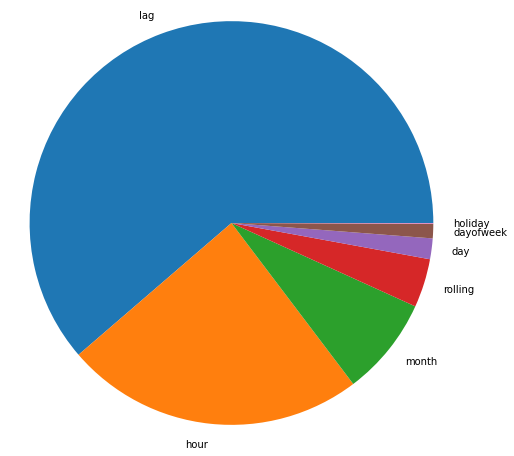

In [20]:
vals = importances['Importance']
labels = importances['Feature']
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(vals, labels=labels, pctdistance=1)
ax.axis("equal")

#### LGBM

In [21]:
model_LGBM = lgb.LGBMRegressor(max_depth=2, num_leaves=70, learning_rate=0.3, n_estimators=80)

model_LGBM.fit(features_full, target_full)
predictions_valid = model_LGBM.predict(features_test)

mean_squared_error(predictions_valid, target_test) ** 0.5

39.9650729319417

Также оценим важность признаков

In [22]:
importances = pd.DataFrame(index = features.columns,
                     columns=['Feature', 'Importance'])
importances.Importance = model_LGBM.feature_importances_

importances.Feature = importances.index

importances.Feature = importances.Feature.apply(feature_group) # применим функцию к столбцу Feature

importances = importances.groupby(by=['Feature']).sum().sort_values(by='Importance', ascending=False)
importances = importances.reset_index()
importances

,Feature,Importance
0,lag,120
1,hour,59
2,day,18
3,rolling,15
4,month,14
5,dayofweek,10
6,holiday,0


(-1.1059755558176168,
 1.1002845535424652,
 -1.1060104136036764,
 1.1036396670267448)

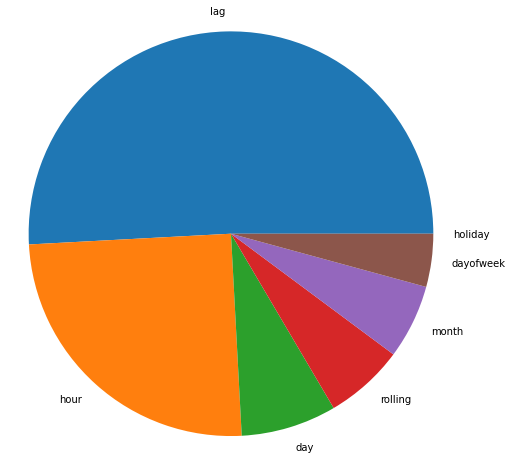

In [23]:
vals = importances['Importance']
labels = importances['Feature']
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(vals, labels=labels, pctdistance=1)
ax.axis("equal")

### Вывод:
Все три модели были дообучены на валидационной выборке и проверены на тестовой. Лучшее качество прогнозов показала LGBM (RMSE=39.97). Неплохой результат также показала модель случайного леса (RMSE=42.32). Линейная регрессия не соответствует заданным в задаче критериям (RMSE=52.75 > 48).

# Общий вывод <a id='section5'></a>

Были подготовлены признаки для обучения. Также обучены три модели с оптимальными гиперпараметрами (линейная регрессия, случайный лес, LGBM).

Качество предсказаний на валидационных данных у трех моделей различалось не очень сильно. Было принято решение дообучить модели на валидационных данных и проверить на тестовых. 

Лучший результат показала LGBM (RMSE=39.97), за ней идет случайный лес (RMSE=42.32). Линейная регрессия не уложилась в заданный критерий (RMSE=52.75 > 48).

Анализ важности признаков показал, что случайный лес и LGBM в первую очередь опираются на значения за предыдущие часы (lag), далее на время суток. В обоих моделях праздничные дни почти не влияли на предсказания. 